# TP5 – Compromis Biais/Variance et autre

## I. Chargement et visualisation des données

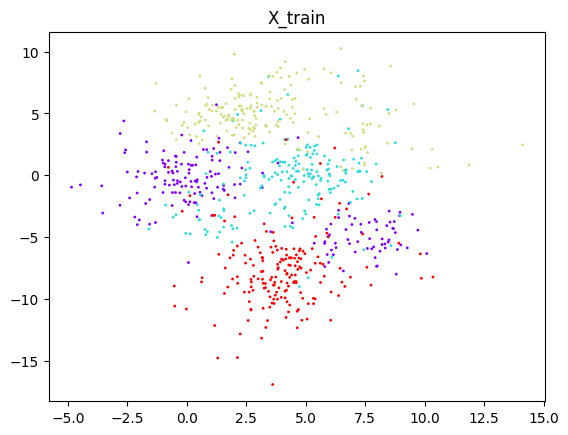

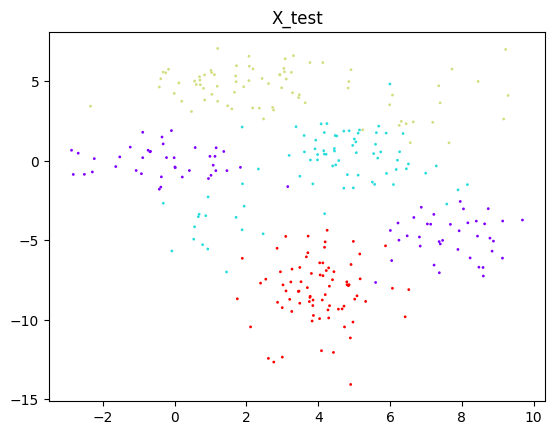

In [110]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load("TP5.npz")
X_train, y_train, X_test, y_test = (data[key] for key in ["X_train", "y_train", "X_test", "y_test"])
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=1, cmap='rainbow');
plt.title("X_train")
plt.show()
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=1, cmap='rainbow');
plt.title("X_test")
plt.show()


Questions \
Combien  y a-t-il de points dans la base d’apprentissage ? Dans la base de test ? Quelle est la 
dimension des données ? \
Combien  y  a-t-il  de  classes ?  Est-ce  que  les  classes  sont  bien  équilibrées  dans  la  base 
d’apprentissage et la base de test ?

Il y a 748 points dans la base d'apprentissage
Il y a 312 points dans la base de test
Les donées sont en 2 dimention
Il y a 4 classes


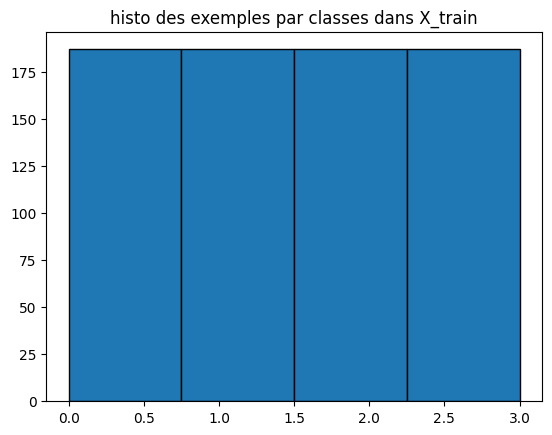

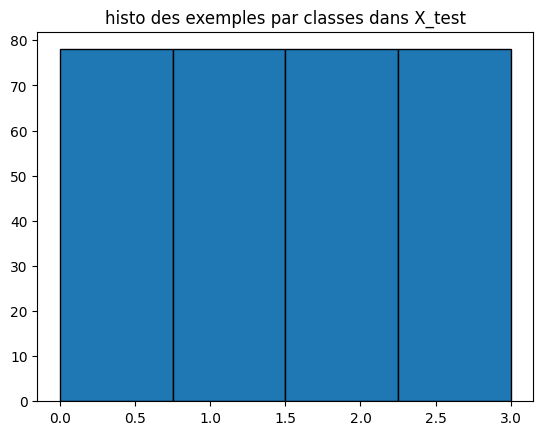

In [111]:
print(f"Il y a {X_train.shape[0]} points dans la base d'apprentissage")
print(f"Il y a {X_test.shape[0]} points dans la base de test")
print(f"Les donées sont en {X_train.shape[1]} dimention")
print(f"Il y a {np.unique(y_train).shape[0]} classes")
plt.hist(y_train,4,ec='black');plt.title("histo des exemples par classes dans X_train"); plt.show()
plt.hist(y_test,4,ec='black');plt.title("histo des exemples par classes dans X_test"); plt.show()

Les classes sont donc bien équilibrées

## II. Calcul du biais et de la variance du classifieur 1PPV

In [112]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import mode


In [113]:
scaler = StandardScaler()
#train
scaler.fit(X_train)
print("moyenne : ",scaler.mean_)
print("ecart-type : ",np.sqrt(scaler.var_)) #or scaler.scale_
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

moyenne :  [ 3.58717926 -1.22246526]
ecart-type :  [2.85879137 5.19181556]


In [114]:
def biais_variance_kppv(k):
    y_preds=[]
    Nrun = 30
    for nrun in range(0,Nrun):
        (X_train_i, _, y_train_i, _) = train_test_split(X_train_scaled,y_train,test_size=0.40,random_state=4+2+5+nrun)
        neigh = KNeighborsClassifier(n_neighbors=k) #default metric : euclidian
        neigh.fit(X_train_i, y_train_i)
        y_preds.append(neigh.predict(X_test_scaled))

    modes = mode(y_preds, axis=0)
    biais = np.where(modes.mode == y_test, 0, 1)
    variance = 1 - modes.count/len(y_preds)
    biais = np.mean(biais)
    variance = np.mean(variance)
    return biais, variance

biais, variance = biais_variance_kppv(1)
print(f'Biais moyen = {biais:.2f}, Variance moyenne = {variance:.2f}')

Biais moyen = 0.15, Variance moyenne = 0.08


## III. Etude du compromis biais/variance du classifieur k-PPV

In [115]:
# évolution du biais et de la variance en fonction du k des k-ppv
N = 60
biais = []
variance = []
for k in range (1,N):
    biais_i, variance_i = biais_variance_kppv(k)
    biais.append(biais_i)
    variance.append(variance_i)


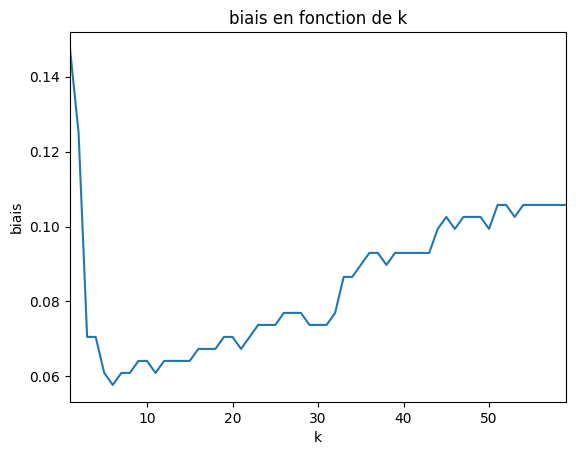

minimum biais = 0.0577, pour k = 6


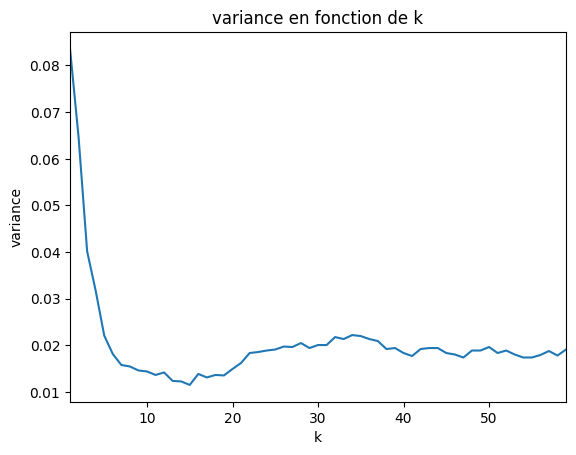

minimum variance = 0.0115, pour k = 15


In [116]:

plt.title('biais en fonction de k')
plt.ylabel('biais')
plt.xlabel('k')
plt.plot(range(1,N),biais)
plt.xlim(1,N-1)
plt.show()
print(f'minimum biais = {np.min(biais):.4f}, pour k = {np.argmin(biais)+1}')

plt.title('variance en fonction de k')
plt.ylabel('variance')
plt.xlabel('k')
plt.plot(range(1,N),variance)
plt.xlim(1,N-1)
plt.show()
print(f'minimum variance = {np.min(variance):.4f}, pour k = {np.argmin(variance)+1}')

Questions\
Comment évoluent le biais et la variance avec k ? Retrouve-t-on la théorie ? Comment trouver 
la valeur de k qui optimise le compromis Biais, variance ?

Le biais et la variance diminuent d'abord rapidement pour les 2-3 premiers k voisins.\
Puis, on observe le phénomène de sous-apprentissage quand k augmente : le biais augmente avec k, la variance continue de diminuer, puis reste faible. Ce qui correspond bien à la théorie.

minimum distance_euclidienne = 0.0605, pour k = 6


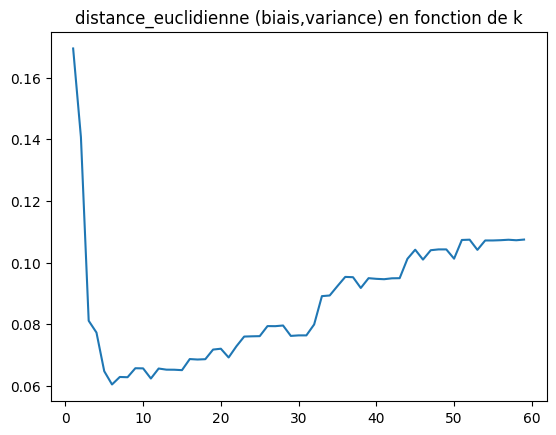

In [117]:
distance_euclidienne = np.sqrt(np.array(biais)**2 + np.array(variance)**2)
plt.title('distance_euclidienne (biais,variance) en fonction de k')
plt.plot(range(1,N),distance_euclidienne)
print(f'minimum distance_euclidienne = {np.min(distance_euclidienne):.4f}, pour k = {np.argmin(distance_euclidienne)+1}')

Le compromis optimal semble être pour k = 6 .\
Soit pour le biais minimal car le bais augmente plus que la variance ne diminue.

## IV. Reprendre la même étude en utilisant un arbre de décision

In [118]:
from sklearn import tree 

In [119]:
#biais_variance_tree pour  maxdepth = 1
def biais_variance_tree(maxdepth):
    y_preds=[]
    Nrun = 30
    for nrun in range(0,Nrun):
        (X_train_i, _, y_train_i, _) = train_test_split(X_train_scaled,y_train,test_size=0.40,random_state=4+2+5+nrun)
        tree1 = tree.DecisionTreeClassifier(criterion='entropy', max_depth = maxdepth, random_state= 425) 
        tree1.fit(X_train_i, y_train_i)
        y_preds.append(tree1.predict(X_test_scaled))

    modes = mode(y_preds, axis=0)
    biais = np.where(modes.mode == y_test, 0, 1)
    variance = 1 - modes.count/len(y_preds)
    biais = np.mean(biais)
    variance = np.mean(variance)
    return biais, variance

biais, variance = biais_variance_tree(1)
print(f'Biais moyen = {biais:.2f}, Variance moyenne = {variance:.2f}')

Biais moyen = 0.51, Variance moyenne = 0.28


In [120]:
# évolution du biais et de la variance en fonction de la profondeur (maximale)
N = 15
biais = []
variance = []
for maxdepth in range (1,N):
    biais_i, variance_i = biais_variance_tree(maxdepth)
    biais.append(biais_i)
    variance.append(variance_i)


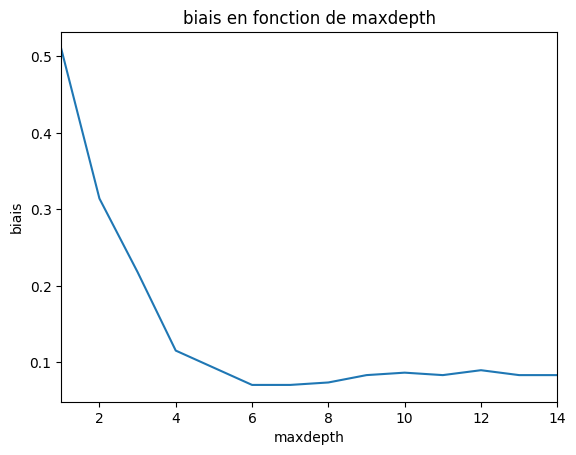

minimum biais = 0.0705, pour maxdepth = 6


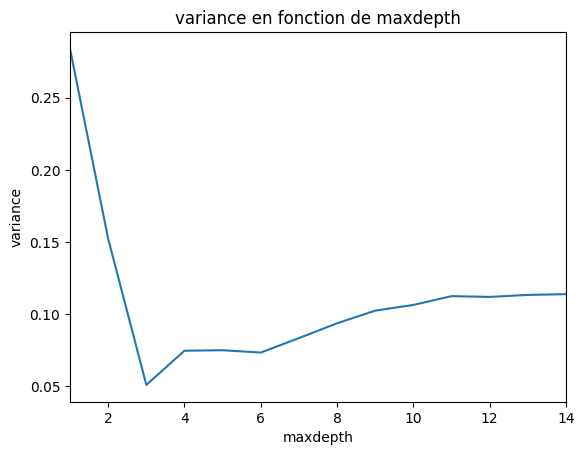

minimum variance = 0.0510, pour maxdepth = 3


In [121]:
plt.title('biais en fonction de maxdepth')
plt.ylabel('biais')
plt.xlabel('maxdepth')
plt.plot(range(1,N),biais)
plt.xlim(1,N-1)
plt.show()
print(f'minimum biais = {np.min(biais):.4f}, pour maxdepth = {np.argmin(biais)+1}')

plt.title('variance en fonction de maxdepth')
plt.ylabel('variance')
plt.xlabel('maxdepth')
plt.plot(range(1,N),variance)
plt.xlim(1,N-1)
plt.show()
print(f'minimum variance = {np.min(variance):.4f}, pour maxdepth = {np.argmin(variance)+1}')

Question\
Comment évoluent le biais et la variance avec k ? Retrouve-t-on la théorie ?Comment trouver 
la valeur de k qui optimise le compromis Biais/variance ?

On observe à l'inverse que cette fois c'est la variance qui semble remonter quand la profondeur grandit, tandis que le biais diminue puis reste faible.
On a à l'inverse des kppv les caractéristiques d'un phénomène de sur-apprentissage quand la profondeur augmente, ce qui est fidèle à la théorie.

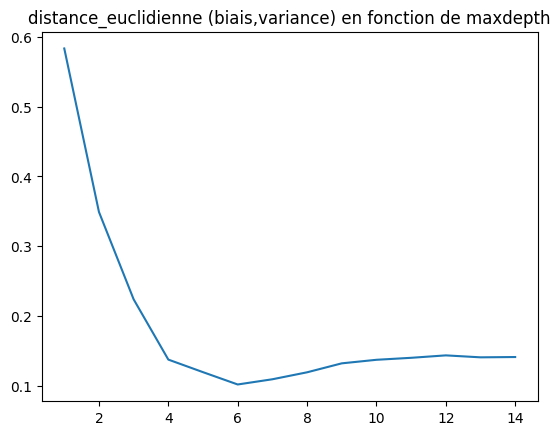

minimum distance_euclidienne = 0.101780, pour maxdepth = 6


In [122]:
distance_euclidienne = np.sqrt(np.array(biais)**2 + np.array(variance)**2)
plt.title('distance_euclidienne (biais,variance) en fonction de maxdepth')
plt.plot(range(1,N),distance_euclidienne)
plt.show()
print(f'minimum distance_euclidienne = {np.min(distance_euclidienne):.6f}, pour maxdepth = {np.argmin(distance_euclidienne)+1}')

Une profondeur de 6 semble être un compromis optimal, demême que pour les kppv, le biais semble varier plus fortement que la variance

## V. Reprendre la même étude avec les random forest 

In [123]:
from sklearn.ensemble import RandomForestClassifier 

In [124]:
#biais_variance_RandomForest pour  maxdepth = 1
def biais_variance_RandomForest(nb_arbres):
    y_preds=[]
    Nrun = 30
    for nrun in range(0,Nrun):
        (X_train_i, _, y_train_i, _) = train_test_split(X_train_scaled,y_train,test_size=0.40,random_state=4+2+5+nrun)
        rf = RandomForestClassifier(criterion='entropy', n_estimators=nb_arbres, random_state=425) 
        rf.fit(X_train_i, y_train_i)
        y_preds.append(rf.predict(X_test_scaled))

    modes = mode(y_preds, axis=0)
    biais = np.where(modes.mode == y_test, 0, 1)
    variance = 1 - modes.count/len(y_preds)
    biais = np.mean(biais)
    variance = np.mean(variance)
    return biais, variance

biais, variance = biais_variance_RandomForest(1)
print(f'Biais moyen = {biais:.2f}, Variance moyenne = {variance:.2f}')

Biais moyen = 0.07, Variance moyenne = 0.14


In [125]:
# évolution du biais et de la variance en fonction du nombre d'arbres de la forêt
N = 30
biais = []
variance = []
for nb_arbres in range (1,N):
    biais_i, variance_i = biais_variance_RandomForest(nb_arbres)
    biais.append(biais_i)
    variance.append(variance_i)


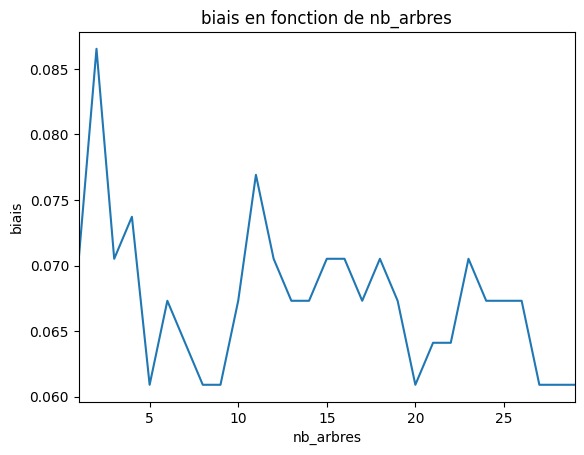

minimum biais = 0.0609, pour nb_arbres = 5


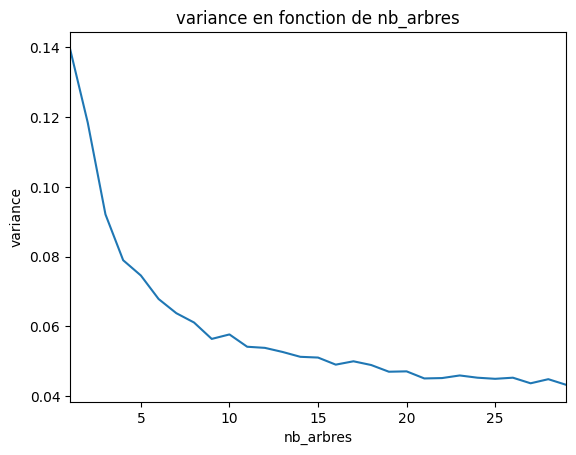

minimum variance = 0.0433, pour nb_arbres = 29


In [126]:
plt.title('biais en fonction de nb_arbres')
plt.ylabel('biais')
plt.xlabel('nb_arbres')
plt.plot(range(1,N),biais)
plt.xlim(1,N-1)
plt.show()
print(f'minimum biais = {np.min(biais):.4f}, pour nb_arbres = {np.argmin(biais)+1}')

plt.title('variance en fonction de nb_arbres')
plt.ylabel('variance')
plt.xlabel('nb_arbres')
plt.plot(range(1,N),variance)
plt.xlim(1,N-1)
plt.show()
print(f'minimum variance = {np.min(variance):.4f}, pour nb_arbres = {np.argmin(variance)+1}')

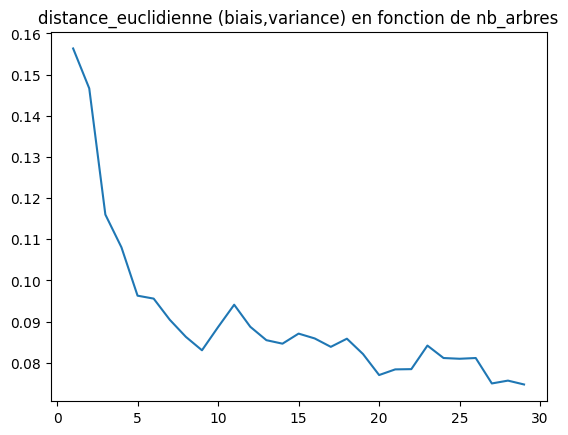

minimum distance_euclidienne = 0.074704, pour nb_arbres = 29


In [127]:
distance_euclidienne = np.sqrt(np.array(biais)**2 + np.array(variance)**2)
plt.title('distance_euclidienne (biais,variance) en fonction de nb_arbres')
plt.plot(range(1,N),distance_euclidienne)
plt.show()
print(f'minimum distance_euclidienne = {np.min(distance_euclidienne):.6f}, pour nb_arbres = {np.argmin(distance_euclidienne)+1}')

Questions \
Comment évoluent le biais et la variance avec Nb ? Retrouve-t-on la théorie ? Trouver la 
valeur de Nb qui optimise le compromis Biais/variance ?

On observe que le biais est très faible, quasi-constant tandis que la variance diminue avec le nombre d'arbres. En efet par defaut la fonction effectue du bagging, ce qui augmente la diversité de la forêt plus elle est grande, ce qui au final contribue à empêcher un sur-apprentissage et donc à garantir une diminution de la variance.

Plus la forêt est grande, mieux le résultat semble être.\
Un forêt de 20 arbres semble ici suffisant

## VI. Test sur un nouveau jeu de données

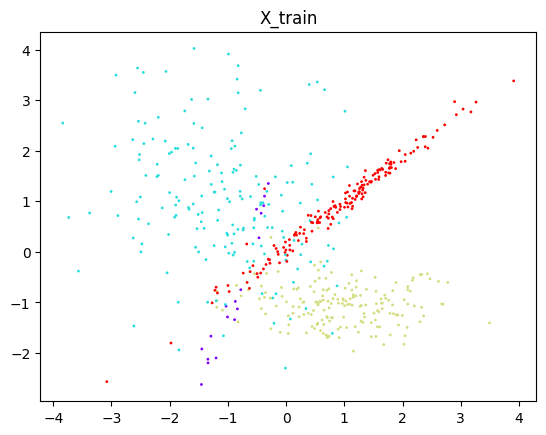

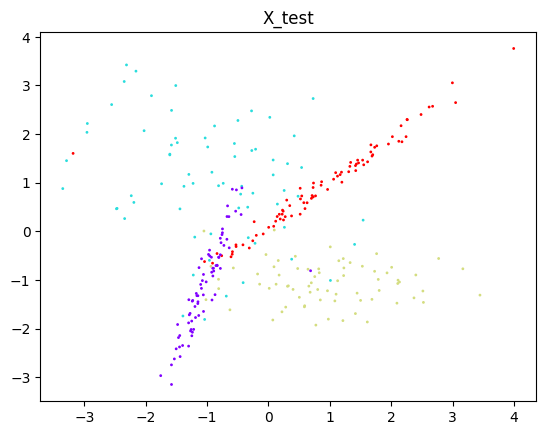

In [128]:
data = np.load("TP5a.npz")
X_train, y_train, X_test, y_test = (data[key] for key in ["X_train", "y_train", "X_test", "y_test"])
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=1, cmap='rainbow');
plt.title("X_train")
plt.show()
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=1, cmap='rainbow');
plt.title("X_test")
plt.show()

Il y a 546 points dans la base d'apprentissage
Il y a 300 points dans la base de test
Les donées sont en 2 dimention
Il y a 4 classes


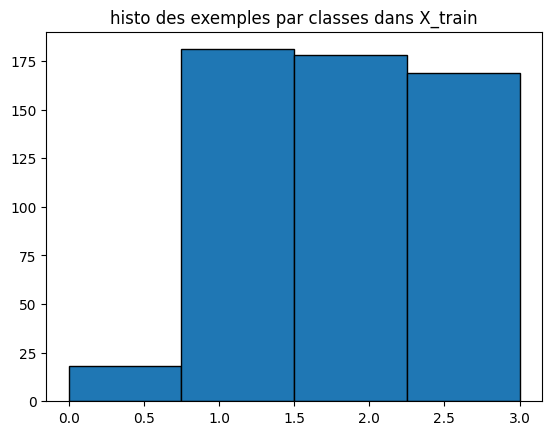

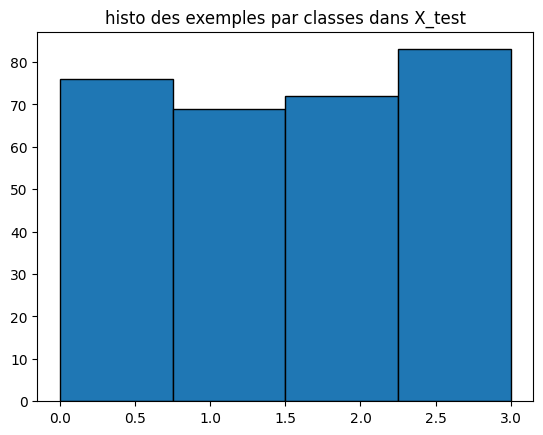

In [129]:
print(f"Il y a {X_train.shape[0]} points dans la base d'apprentissage")
print(f"Il y a {X_test.shape[0]} points dans la base de test")
print(f"Les donées sont en {X_train.shape[1]} dimention")
print(f"Il y a {np.unique(y_train).shape[0]} classes")
plt.hist(y_train,4,ec='black');plt.title("histo des exemples par classes dans X_train"); plt.show()
plt.hist(y_test,4,ec='black');plt.title("histo des exemples par classes dans X_test"); plt.show()

On observe que la classe 0 est sous-représentée en apprentissage !

In [130]:
scaler = StandardScaler()
#train
scaler.fit(X_train)
#print("moyenne : ",scaler.mean_)
#print("ecart-type : ",np.sqrt(scaler.var_)) #or scaler.scale_
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [131]:
#biais_variance_RandomForest
def biais_variance_RandomForest(nb_arbres, X_train_scaled, y_train, X_test_scaled, y_test):
    y_preds=[]
    Nrun = 30
    for nrun in range(0,Nrun):
        (X_train_i, _, y_train_i, _) = train_test_split(X_train_scaled,y_train,test_size=0.40,random_state=4+2+5+nrun)
        rf = RandomForestClassifier(criterion='entropy', n_estimators=nb_arbres, random_state=425) 
        rf.fit(X_train_i, y_train_i)
        y_preds.append(rf.predict(X_test_scaled))

    modes = mode(y_preds, axis=0)
    biais = np.where(modes.mode == y_test, 0, 1)
    variance = 1 - modes.count/len(y_preds)
    biais = np.mean(biais)
    variance = np.mean(variance)
    return biais, variance


In [132]:
nb_arbres = 20
biais, variance = biais_variance_RandomForest(nb_arbres, X_train_scaled, y_train, X_test_scaled, y_test)
print(f'Biais moyen = {biais:.2f}, Variance moyenne = {variance:.2f}')

Biais moyen = 0.23, Variance moyenne = 0.11


In [133]:
from sklearn.metrics import classification_report
def RandomForest(nb_arbres, X_train_scaled, y_train, X_test_scaled, y_test):
    (X_train_i, _, y_train_i, _) = train_test_split(X_train_scaled,y_train,test_size=0.40,random_state=4+2+5+nrun)
    rf = RandomForestClassifier(criterion='entropy', n_estimators=nb_arbres, random_state=425) 
    rf.fit(X_train_i, y_train_i)
    y_pred = rf.predict(X_test_scaled)
    print(classification_report(y_test, y_pred))


In [134]:
RandomForest(nb_arbres, X_train_scaled, y_train, X_test_scaled, y_test)

              precision    recall  f1-score   support

           0       0.76      0.29      0.42        76
           1       0.67      0.71      0.69        69
           2       0.69      0.89      0.78        72
           3       0.74      0.94      0.83        83

    accuracy                           0.71       300
   macro avg       0.72      0.71      0.68       300
weighted avg       0.72      0.71      0.68       300



Conséquence de manque d'exemples de la classe 0 en apprentissage : le biais semble anormalement élevé.\
Si on regarde de plus près la classe 0 a un très mauvais taux de rappel.



On peut remédier à ce problème en rajoutant des exemples de la classe 0 en apprentissage (soit des vrais exemples, soit des exemples générés).\
On peut aussi rééquilibrer en priorisant une base d'apprentissage équilibrée sur la base de test. C'est à dire de faire un partage des deux bases (test/train) qui garanti l'équilibre (approximatif) de la base d'entraînement. Mais celà peut conduire à d'autres problèmes comme le partage n'est alors plus vraiment aléatoire.

La meilleur solution (si on ne peux pas obtenir d'autres exemples réels) serait de calculer les caractéristiques de la classe 0 (loi de probabilité, et ses paramètres) et de générer des exemples représentatifs de la classe jusqu'à équilibre.